# Лабораторная работа №6 (Catboost)
## Выполнил Неженский Михаил Сергеевич, 6133-010402D

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

Используемый в работе набор данных: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, confusion_matrix

In [3]:
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

In [5]:
diabetes = 'diabetes_prediction_dataset.csv'
data = pd.read_csv(diabetes)
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [6]:
data_new = data.select_dtypes(include=np.number)
data_new.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80.0,0,1,25.19,6.6,140,0
1,54.0,0,0,27.32,6.6,80,0
2,28.0,0,0,27.32,5.7,158,0
3,36.0,0,0,23.45,5.0,155,0
4,76.0,1,1,20.14,4.8,155,0


In [11]:
# преобразуем в целые (чтобы можно было с ними работать, как с категориальными)
df = data_new.dropna(how='any',axis=0) 
df['age'] = df['age'].apply(lambda val: int(val))
df['bmi'] = df['bmi'].apply(lambda val: int(val))
df['HbA1c_level'] = df['HbA1c_level'].apply(lambda val: int(val))

In [12]:
df.head(10)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80,0,1,25,6,140,0
1,54,0,0,27,6,80,0
2,28,0,0,27,5,158,0
3,36,0,0,23,5,155,0
4,76,1,1,20,4,155,0
5,20,0,0,27,6,85,0
6,44,0,0,19,6,200,1
7,79,0,0,23,5,85,0
8,42,0,0,33,4,145,0
9,32,0,0,27,5,100,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   age                  100000 non-null  int64
 1   hypertension         100000 non-null  int64
 2   heart_disease        100000 non-null  int64
 3   bmi                  100000 non-null  int64
 4   HbA1c_level          100000 non-null  int64
 5   blood_glucose_level  100000 non-null  int64
 6   diabetes             100000 non-null  int64
dtypes: int64(7)
memory usage: 5.3 MB


In [14]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.875660,0.07485,0.039420,26.874580,5.132440,138.058060,0.085000
std,22.535417,0.26315,0.194593,6.641976,1.101114,40.708136,0.278883
min,0.000000,0.00000,0.000000,10.000000,3.000000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.000000,4.000000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.000000,5.000000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.000000,6.000000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.000000,9.000000,300.000000,1.000000


Будем определять болен человек диабетом в зависимости от его показателей или нет

In [11]:
# Выделение целевой переменной

Y = df.diabetes
X = df.drop('diabetes', axis=1)

In [12]:
# Делим на обучающую и тестовую

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)

In [13]:
# Объявление категориальных факторов

cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [14]:
print('Labels: '.format(set(Y)))
print('Zero count = ' + str(len(Y) - sum(Y)) + ', One count = ' + str(sum(Y)))

Labels: 
Zero count = 91500, One count = 8500


### 1. Применить классификатор CatBoostClassifier к вашему датасету (бинарная или multiclass классификация по желанию).
Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.
Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо)

In [15]:
# Обучение модели

model = CatBoostClassifier(
    iterations = 100,
    learning_rate = 0.5,
    random_seed = 8,
    custom_loss = ['AUC', 'Accuracy'],
    logging_level='Info'
)
model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    logging_level='Silent'   
)


In [16]:
# параметры модели
print()
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:' + str(model.get_params()))

# лучшие параметры модели
print()
best_it = model.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model.best_score_
print('Best score:'  + str(best_sc))


Model is fitted: True
Model params:{'iterations': 100, 'learning_rate': 0.5, 'random_seed': 8, 'logging_level': 'Info', 'custom_loss': ['AUC', 'Accuracy']}

Best iteration: 93
Best score:{'learn': {'Accuracy': 0.948325, 'Logloss': 0.1504181193383643}, 'validation': {'Accuracy': 0.9467, 'Logloss': 0.15025670632356072, 'AUC': 0.9242356464047631}}


In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score


In [18]:
# метрики
accur = accuracy_score(Y_test, model.predict(X_test))
roc = roc_auc_score(Y_test, model.predict(X_test))
prec = precision_score(Y_test, model.predict(X_test))
rec = recall_score(Y_test, model.predict(X_test))

In [19]:
print('Accuracy:'  + str(accur))
print('AUC: ' + str(roc))
print('Precision: ' + str(prec))
print('Recall: ' + str(rec))

Accuracy:0.94655
AUC: 0.6916142944379421
Precision: 0.9865470852017937
Recall: 0.38372093023255816


### 3. Для бинарного классификатора на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

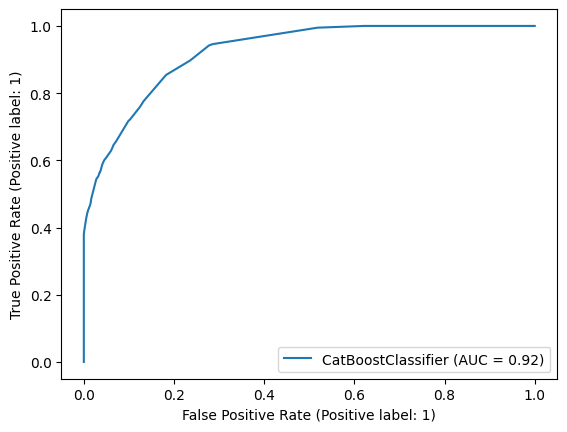

In [20]:
from sklearn.metrics import RocCurveDisplay
svc_disp = RocCurveDisplay.from_estimator(model, X_test, Y_test)

In [21]:
from sklearn.metrics import PrecisionRecallDisplay

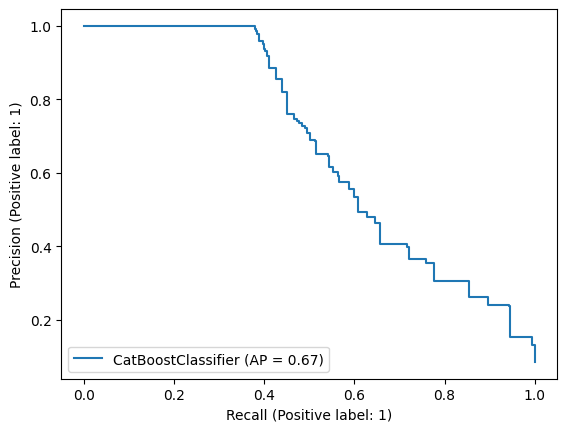

In [22]:
# PRC-кривая и PRC-AUC
PrecisionRecallDisplay.from_estimator(model, X_test, Y_test)

### 2. Применить регрессию CatBoostRegressor к датасету. Вывести номер итерации с значения метрик (MAE и MSE) для наилучшей итерации.

In [23]:
model1 = CatBoostRegressor(
    custom_metric=["MAE", "RMSE"], 
    cat_features = cat_features
)

model1.fit(
    X_train, Y_train,
    eval_set=(X_test, Y_test),
    logging_level='Silent'
)

In [24]:
# лучшие параметры модели
print()
best_it = model1.get_best_iteration()
print('Best iteration: ' + str(best_it))
best_sc = model1.best_score_
print('Best score:'  + str(best_sc))


Best iteration: 116
Best score:{'learn': {'MAE': 0.08477308773061289, 'RMSE': 0.20290432807501338}, 'validation': {'MAE': 0.08581045271375216, 'RMSE': 0.20787375231492383}}


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [26]:
# метрики качества регрессии
mae1 = mean_absolute_error(Y_test, model1.predict(X_test))
print('MAE: ', mae1)
mse1 = mean_squared_error(Y_test, model1.predict(X_test))
print('MSE: ', mse1)

MAE:  0.08659289405160167
MSE:  0.043211496901486214
